# Justin Note

This notebook combines the augmentation proposed in YoloV3 with pretrained data from Pseudo Labeling?

# Train and Inference for FasterRCNN with Augmentation
In this notebook I am going to share the train and inference code for FasterRCNN coupled with multiple Augmentation Tricks.
<br>
Huge thanks to these sources for making this attempt a success:
* [Augmentation code](https://www.kaggle.com/nvnnghia/awesome-augmentation)
* [Original Augmentation Reference](https://github.com/ultralytics/yolov3)
* [Some Parts of Training Code](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
* [Inference Code](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

For EDA and Beginner Friendly code checkout [this](https://www.kaggle.com/yashchoudhary/gwd-eda-and-starter-code-beginner-friendly) notebook.

# Setup

Define all of our input paths and stuff. I put the kaggle data in "data" folder here

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
godimg = 0
DIR_INPUT = 'data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

# Augmentation functions

Defines a set of augmentation functions, they do like weird shifting and cut and mixing. They're all just copy-pasted from the Yolov3 repo

These augmentations are inspired by [CutMix](https://arxiv.org/abs/1905.04899) and [MixMatch](https://arxiv.org/abs/1905.02249).<br>
[Source](https://github.com/ultralytics/yolov3)

In [3]:
def load_image(self, index):
    # loads 1 image from dataset, returns img, original hw, resized hw
    image_id = self.image_ids[index]
    imgpath = f'{DIR_INPUT}/train'
    img = cv2.imread(f'{imgpath}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
    assert img is not None, 'Image Not Found ' + imgpath
    h0, w0 = img.shape[:2]  # orig hw
    return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized


In [4]:
def load_mosaic(self, index):
    # loads images in a mosaic

    labels4 = []
    s = self.img_size
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(self, index)

        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove

    return img4, labels4


In [5]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

In [6]:
def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [7]:
def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

# Creating the Train and Test Dataset

train dataset has all the augmentations and the test dataset doesn't

In [8]:
from sklearn.utils import shuffle
import random

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.image_ids = shuffle(self.image_ids)
        # labels correspond to box coords for yolo
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.image_ids)
        self.img_size = 1024
        im_w = 1024
        im_h = 1024
        
        # create the boxes with yolo specs (I think they go off center of box rather than top left)
        for i, img_id in enumerate(self.image_ids):
            records = self.df[self.df['image_id'] == img_id]
            boxes = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxesyolo = []
            for box in boxes:
                x1, y1, x2, y2 = box
                xc, yc, w, h = 0.5*x1/im_w+0.5*x2/im_w, 0.5*y1/im_h+0.5*y2/im_h, abs(x2/im_w-x1/im_w), abs(y2/im_h-y1/im_h)
                boxesyolo.append([0, xc, yc, w, h])
            self.labels[i] = np.array(boxesyolo)
        
        self.image_dir = image_dir
        self.transforms = transforms
        
        self.mosaic = False
        self.augment = True

    def __getitem__(self, index: int):

        # This just does load mosaic all the time
        self.mosaic = True
        if random.randint(0,1) == 0:
            self.mosaic = False
        if self.mosaic:
            # Load mosaic
            img, labels = load_mosaic(self, index)
            shapes = None

        else:
            # Load image
            img, (h0, w0), (h, w) = load_image(self, index)

            # Letterbox
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            # Load labels
            labels = []
            x = self.labels[index]
            if x.size > 0:
                # Normalized xywh to pixel xyxy format
                labels = x.copy()
                labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
                labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
                labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]
        
        if self.augment:
            # Augment imagespace
            if not self.mosaic:
                img, labels = random_affine(img, labels,
                                            degrees=0,
                                            translate=0,
                                            scale=0,
                                            shear=0)

            # Augment colorspace
            augment_hsv(img, hgain=0.0138, sgain= 0.678, vgain=0.36)
        
        d = {}
        d['boxes'] = torch.from_numpy(labels[:,1:].astype(np.float32))
        d['labels'] = torch.ones((labels[:,0].shape[0],), dtype=torch.int64)
        
        return torch.from_numpy(torch.from_numpy(img).permute(2, 0, 1).numpy().astype(np.float32) / 255.0), d

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Setting-up Dataloaders

In [10]:
import random, math
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

# split into train/val and also make test set
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())
test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

# Show some samples

look at the augmented data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: tuple index out of range

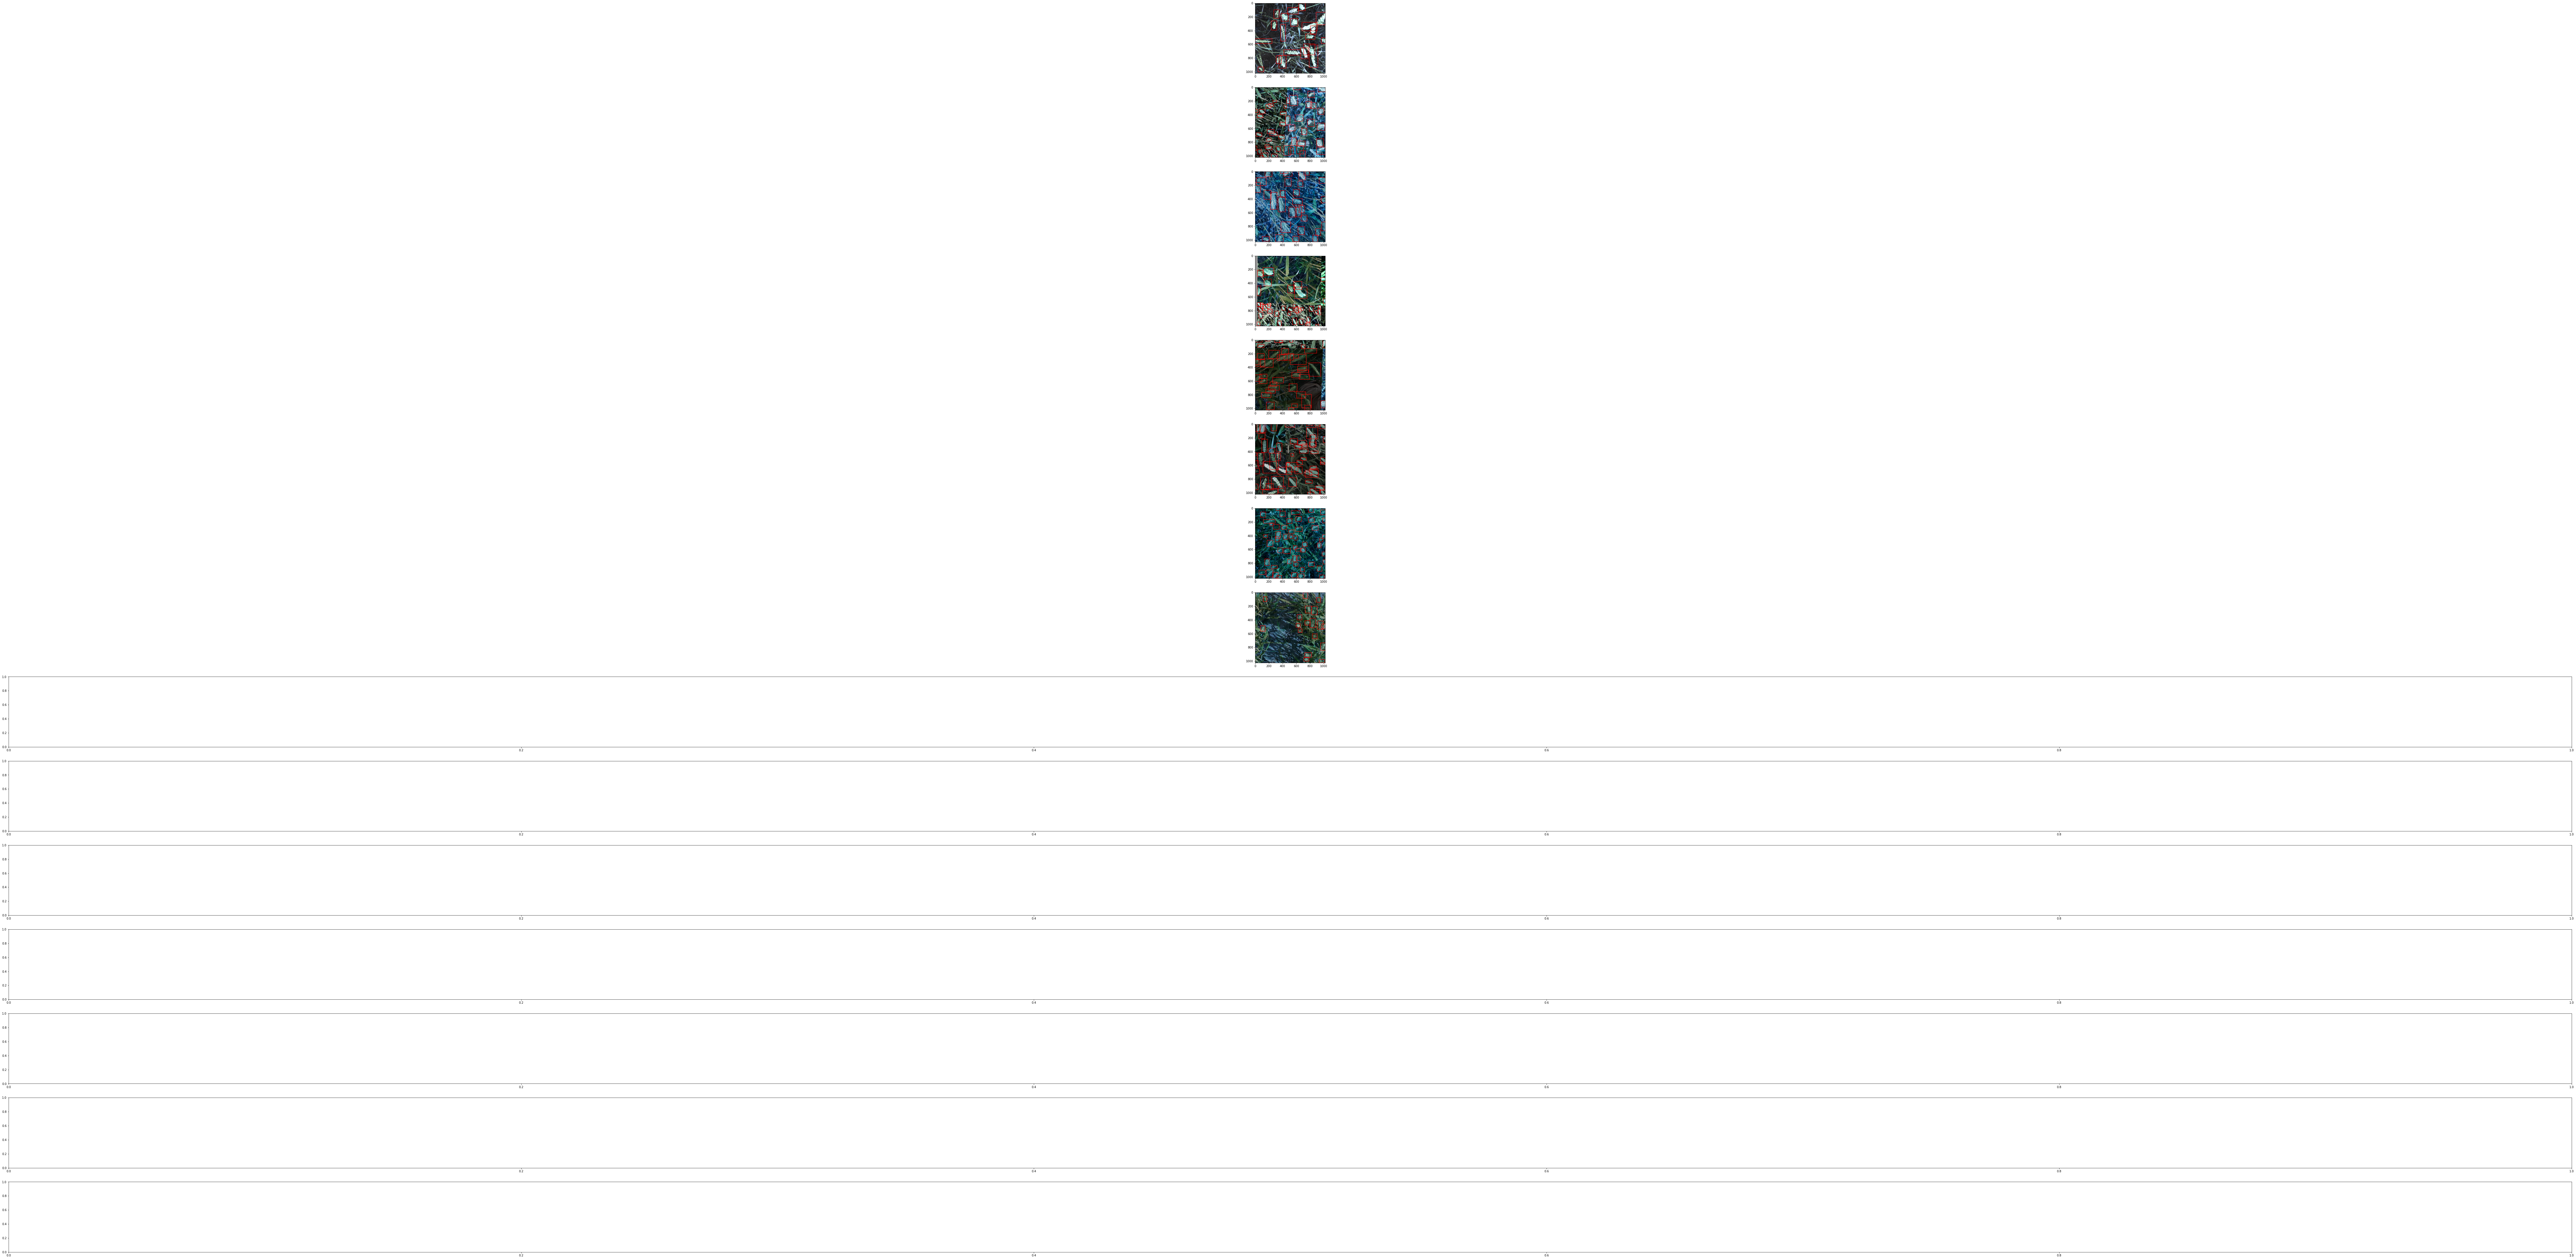

In [11]:
# images, targets = next(iter(train_data_loader))
# fig, ax = plt.subplots(15, 1, figsize=(160, 80))

# for i in range(15):  
#     boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
#     sample = images[i].permute(1,2,0).cpu().numpy()

#     for box in boxes:
#         cv2.rectangle(sample,
#                   (int(box[0]), int(box[1])),
#                   (int(box[2]), int(box[3])), 
#                    220, 3)

#     ax[i].imshow(sample)
# plt.show()

# Training Code
We will be using pretrained pseudo labeling weights for better results.
<br>
<br>
We will be training for multiple epochs and saving the weights when the validation loss is the least. This will help us in getting the best weights file and avoid overfitting.

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [13]:
WEIGHTS_FILE = "fasterrcnn_resnet50_fpn2nd.pth"

In [14]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(WEIGHTS_FILE))

<All keys matched successfully>

In [15]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Hyperparameters

do the same thing train/val losses 

In [16]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

#lr_scheduler = None

num_epochs = 2 #Increase it for better results

In [17]:
loss_hist = Averager()
val_loss_hist = Averager()
itr = 1
least_loss = float('inf')
for epoch in range(num_epochs):
    loss_hist.reset()
    val_loss_hist.reset()
    
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    #Validation Step
    for images, targets in valid_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        val_loss_dict = model(images, targets)

        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()

        val_loss_hist.send(val_loss_value)

    
    # update the learning rate
    if val_loss_hist.value<least_loss:
        least_loss = val_loss_hist.value
        lval=int(least_loss*1000)/1000
        torch.save(model.state_dict(), f'fasterrcnn_custom_test_ep{epoch}_loss{lval}.pth')
        torch.save(model.state_dict(), 'best_weights.pth')
        
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    print(f"Epoch #{epoch} train_loss: {loss_hist.value} val_loss: {val_loss_hist.value}")

Iteration #50 loss: 0.6219878196716309
Iteration #100 loss: 0.6923762559890747
Iteration #150 loss: 0.6166734099388123
Iteration #200 loss: 0.6495703458786011
Iteration #250 loss: 0.7177696228027344
Iteration #300 loss: 0.6478883028030396
Epoch #0 train_loss: 0.674817239640385 val_loss: 0.6465874921062036
Iteration #350 loss: 0.6253747940063477
Iteration #400 loss: 0.6484878063201904
Iteration #450 loss: 0.6917426586151123
Iteration #500 loss: 0.6602351665496826
Iteration #550 loss: 0.8031178116798401
Iteration #600 loss: 0.675528883934021
Iteration #650 loss: 0.5509682893753052
Epoch #1 train_loss: 0.6388376991657381 val_loss: 0.6331880788603229


# Justin TODO

- Try to store everything in memory instead of using dataloader (figure out how to batch with that), see if that's any faster (possible that it doesn't really help us since the infrastructure loss, but research pytorch to see if they have recommendations here)

- move code around (utils.py file probably)

- Try with more augmentations and different pretrained

- Freeze the train/val splits so we can do offline evaluations on them all

- Misclassification analysis

## TODO
* I will be experimenting with other model architectures and will be posting my findings in future notebooks.

<span style="color:red">NOTE</span>: If you like my work do support me by giving an <span style="color:red">UPVOTE</span>. It matters a lot and keeps me motivated. Thanks.